# Capstone tsne


In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
# Additional python packages
import os, urllib, io, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
import scipy.misc
from ggplot import *
import time
from sklearn.manifold import TSNE

from functions import * # Our functions

init_notebook_mode(connected=True)

## Load images and meta data

In [23]:

images=[]
names=[]
for root, dirs, files in os.walk('final_dataset'):
    for name in files:
        mypath = os.path.join(root,name)
        img=Image.open(mypath)
        arr = np.array(img).astype('uint8')
        images.append(arr)
        img.close()
        names.append(name.split('.')[0])

gene=[name.split('_')[0] for name in names]
days=[int(name.split('_')[1]) for name in names]
biofilm_number=[name.split('_')[2] for name in names]
dic={'label':names,'gene':gene,'days':days,'biofilm_number':biofilm_number}

df_all=pd.DataFrame.from_dict(dic)

## Lets look at some of the images

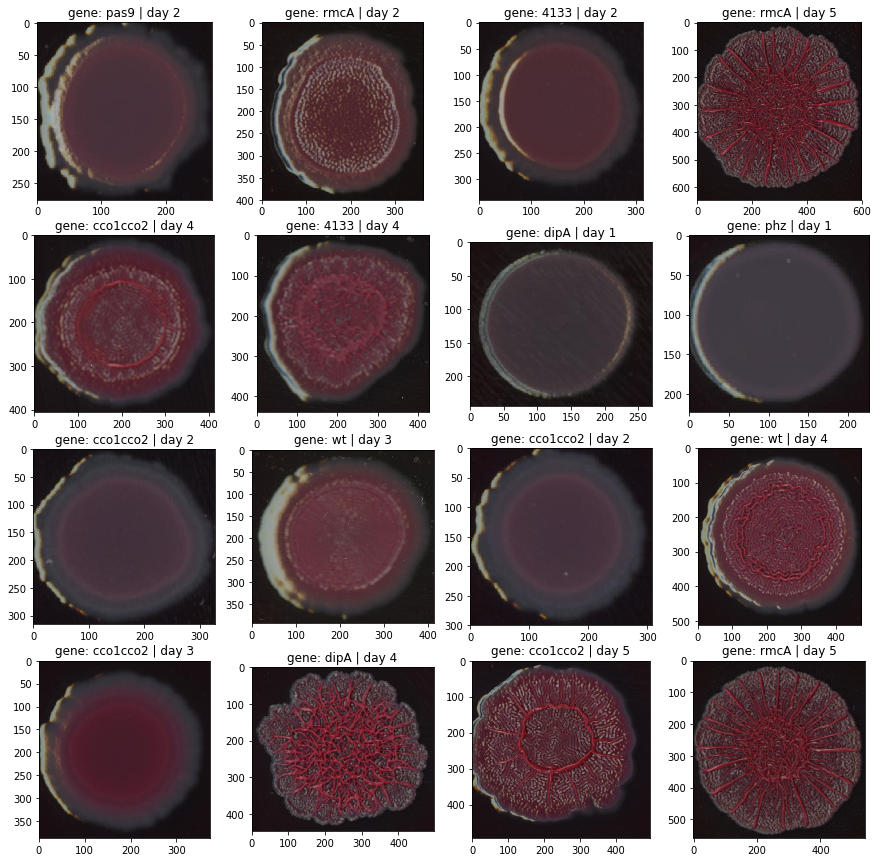

In [24]:
fig = plt.figure(figsize=(15,15))
n = 4

for i,s in enumerate(images):
    try:
        fig.add_subplot(n,n,i+1)
        plt.imshow(s)
        title = 'gene: %s | day %d' %(df_all['gene'][i],df_all['days'][i])
        plt.title(title)
    except:
        pass
plt.show()

### Process Images to find Wrinkles

In [25]:
img_classes=[get_classes(img,threshold_val=0, resize=128, n_clusters=2)[1] for img in images]
perc_wrink = [round(np.count_nonzero(img)/(128**2),2) for img in img_classes]
df_all['perc_wrink'] = perc_wrink

### Plots of processed images

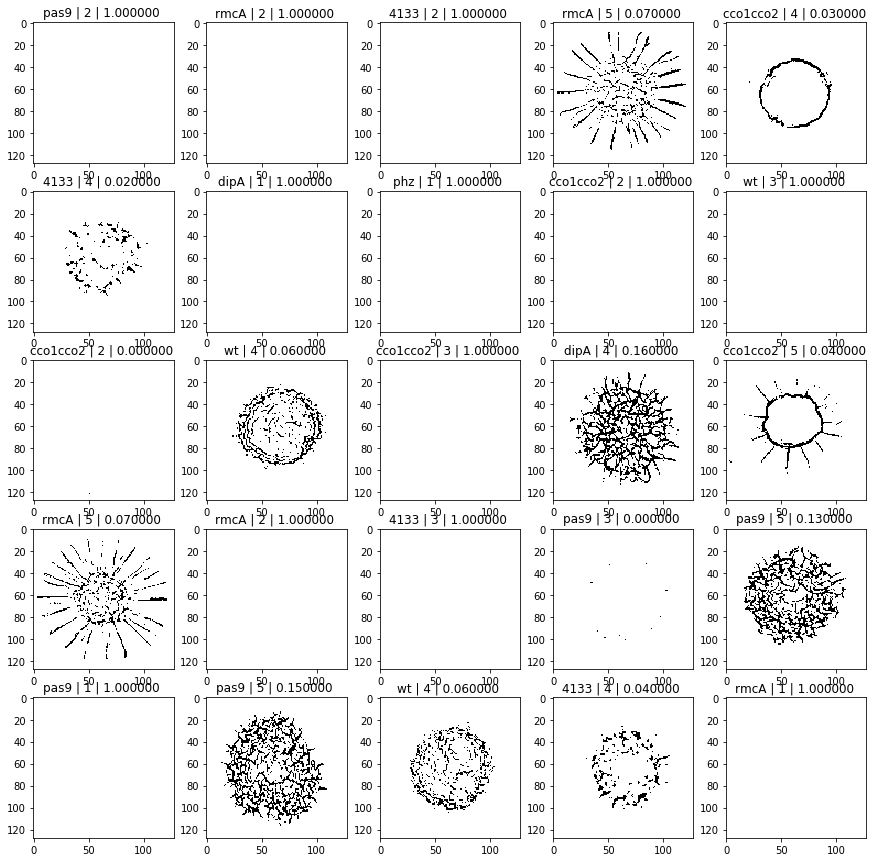

In [26]:
fig = plt.figure(figsize=(15,15))
n = 5

for i,s in enumerate(img_classes):
    try:
        fig.add_subplot(n,n,i+1)
        plt.imshow(s, cmap='binary')
        title = '%s | %d | %f ' %(df_all['gene'][i],df_all['days'][i],df_all['perc_wrink'][i])
        plt.title(title)
    except:
        pass
plt.show()

## Pre-process images for tSNE analysis


### We filter images that have wrinkle percent less than 2%. This mostly eliminates all biofilms that are 1 and 2 days old. 

In [27]:
tsne_data = []
tsne_info = pd.DataFrame(columns=df_all.columns)
for i,img in enumerate(img_classes):
    if perc_wrink[i] > .02 and perc_wrink[i] < 1.0:
        tsne_data.append(img)
        tsne_info = tsne_info.append(df_all.iloc[[i]])
#         t_img = Image.fromarray(img)
#         t_img = t_img.convert('RGB')
#         t_img.save('tsne_dataset/'+img_names[i-1])

In [28]:
# X = [x[:,:,0] for x in X]
X = [x.flatten() for x in tsne_data]
X = np.asarray(X)

In [29]:
labels = tsne_info['gene'].unique()
tsne_info['y'] = [int(np.where(labels==s)[0]) for s in tsne_info['gene']]
y = np.array(tsne_info['y'])

In [30]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame(X,columns=feat_cols)
df['label'] = df_all['gene']
df['label'] = df['label'].apply(lambda i: str(i))

X, y = None, None


print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (531, 16385)


In [31]:
rndperm = np.random.permutation(df.shape[0])

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=250)
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 531 samples in 0.300s...
[t-SNE] Computed neighbors for 531 samples in 8.090s...
[t-SNE] Computed conditional probabilities for sample 531 / 531
[t-SNE] Mean sigma: 1059.526663
[t-SNE] KL divergence after 250 iterations with early exaggeration: 120.537674
[t-SNE] Error after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000
t-SNE done! Time elapsed: 9.763814687728882 seconds


In [32]:
# np.savetxt("tsne_test.csv", tsne_results, delimiter="\t")
# np.savetxt("tsne_labels.tsv",np.array(df['label']))

In [33]:
# a = np.array(df['label'])

In [34]:
# df['label'].to_csv("tsne_labels.csv")

In [35]:
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
# df_tsne['z-tsne'] = tsne_results[:,2]

In [36]:


p = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.6) \
        + ggtitle("tSNE dimensions colored by gene")\
        + xlim(-50,50) \
        + ylim(-50,50) \
        + theme_bw() 

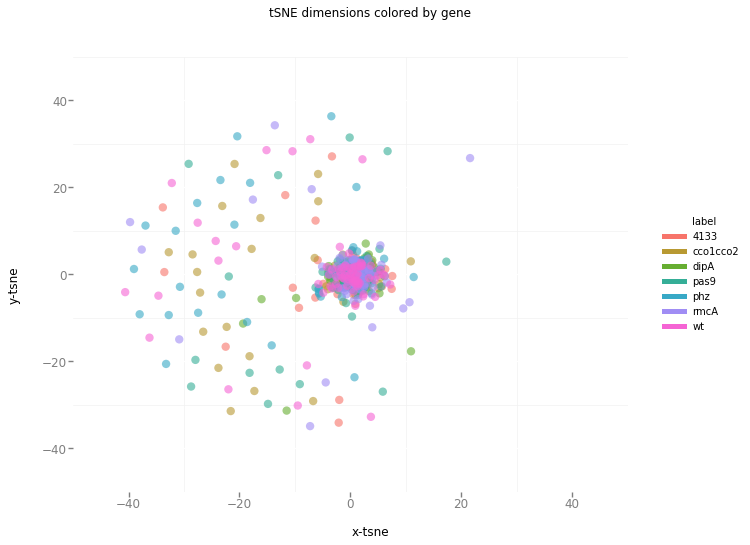

<ggplot: (-9223363278077370161)>

In [37]:
p